# Bike Sharing Analysis with Ford GoBike Data 

***Introduction***

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.
In this project, I will perform an exploratory analysis on data provided by Ford GoBike, a bike-share system provider. 

***Primary Wrangling***

t's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in from 2017 to November, 2018.

Ford GoBike Data: https://s3.amazonaws.com/fordgobike-data/index.html

In [1]:
# import all packages and set plots to be embedded inline
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

In [2]:
# download the dataset with pandas
folder_name_of_csvs = 'trip_data_files'

In [3]:
makedirs(folder_name_of_csvs)
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(folder_name_of_csvs))
for month in range(1,12):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder trip_data_files
    unzipped_file.extractall(folder_name_of_csvs)

In [4]:
# Combine All Locally Saved CSVs into One DataFrame
list_csvs = []
for file_name in listdir(folder_name_of_csvs):
    list_csvs.append(pd.read_csv(folder_name_of_csvs+'/'+file_name))
df = pd.concat(list_csvs)

In [5]:
df.to_csv('data.csv')

In [6]:
# Examine DataFrame
df = pd.read_csv('data.csv')

In [7]:
len(df)

2252058

In [8]:
#Set visualization style
sns.set_style('whitegrid')
sns.set_context("talk")

In [9]:
#Filter data to include reasonable member age range
df['member_age'] = 2018-df['member_birth_year']

In [10]:
# Check age distrubition
df['member_age'].describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .75, .8, .9, .95])

count    2.079810e+06
mean     3.553289e+01
std      1.051074e+01
min      1.800000e+01
10%      2.400000e+01
20%      2.700000e+01
30%      2.900000e+01
40%      3.100000e+01
50%      3.300000e+01
60%      3.600000e+01
70%      3.900000e+01
75%      4.100000e+01
80%      4.400000e+01
90%      5.100000e+01
95%      5.600000e+01
max      1.370000e+02
Name: member_age, dtype: float64

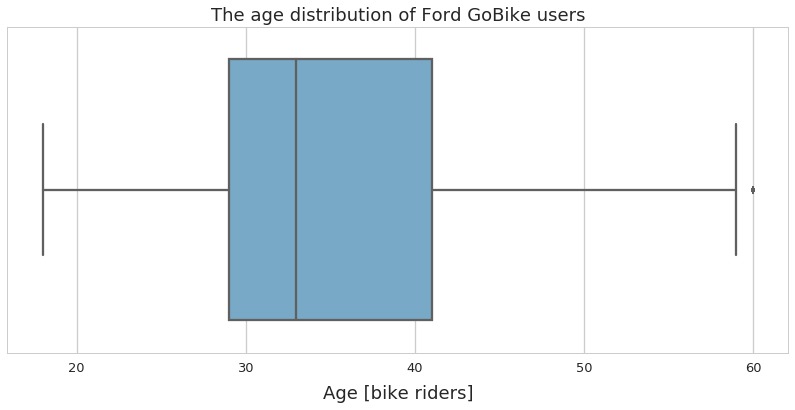

In [28]:
plt.figure(figsize=(14,6))
sns.boxplot(x='member_age', data=df, palette='Blues', orient='h')
plt.title("The age distribution of Ford GoBike users", fontsize=18, y=1.0)
plt.xlabel("Age [bike riders]", fontsize=18, labelpad=10)
plt.savefig('image01.png');

Here is the distrubition of users. Ages from 18 to 56 takes 95% of the users. There were users more than 100 years old. So, we can remove users more than 60 years old.

In [12]:
df = df[df['member_age']<=60]

In [13]:
df['member_age'].mean()

34.783988359178586

In [17]:
df.drop(['Unnamed: 0', 'member_birth_year'], axis=1, inplace=True)

Ford GoBike spreaded the service to San Francisco, Oakland and San Jose. However, it's hard to imagine traffic. So regarding this complexity, I decided to focus on San Fancisco area.

In [18]:
#Filter data only to include San Francisco rides
max_longitude_sf = -122.3597
min_longitude_sf = -122.5147
max_latitude_sf = 37.8121
min_latitude_sf = 37.7092

In [19]:
end_station_latitude_mask = (df['end_station_latitude']>=min_latitude_sf) & (df['end_station_latitude']<=max_latitude_sf)
start_station_latitude_mask = (df['start_station_latitude']>=min_latitude_sf) & (df['start_station_latitude']<=max_latitude_sf)

In [20]:
end_station_longitude_mask =(df['end_station_longitude']>=min_longitude_sf) & (df['end_station_longitude']<=max_longitude_sf)
start_station_longitude_mask = (df['start_station_longitude']>=min_longitude_sf) & (df['start_station_longitude']<=max_longitude_sf)

In [21]:
df = df[end_station_latitude_mask & start_station_latitude_mask & end_station_longitude_mask & start_station_longitude_mask]

In [22]:
len(df)

1505886

In [23]:
# high-level overview of data shape and composition
print(df.shape)
print(df.dtypes)
print(df.head(10))

(1505886, 17)
Unnamed: 0.1               float64
bike_id                      int64
bike_share_for_all_trip     object
duration_sec                 int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name            object
end_time                    object
member_gender               object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name          object
start_time                  object
user_type                   object
member_age                 float64
dtype: object
    Unnamed: 0.1  bike_id bike_share_for_all_trip  duration_sec  \
0            NaN     1035                      No           598   
1            NaN     1673                      No           943   
2            NaN     3498                      No         18587   
3            NaN     3129                      No         18558   
17           NaN     2011                 

***What is the structure of your dataset?***

There are 1505886 rides in the dataset with 16 features like bike_id, user_type, member_age, start_station_name etc. Most variables are numeric in the dataset.

***What is/are the main feature(s) of interest in your dataset?***

I'm most interested in figuring out and understanding the users' behaviors and personal details like;

Average riding duration

Average riding distance

Leisure or to go far away

Age groups of users

Genders

Weekly day distrubition etc. in the dataset.

***What features in the dataset do you think will help support your investigation into your feature(s) of interest?***

I expect that age group and purpose of usage will make a strong effect in the dataset. I also think that the other investigations will clarify the customers' behaviors as well.

***Univariate Exploration***

In [24]:
#Generate new fields for date from start_time and end_time
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])

In [25]:
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date

In [26]:
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))

In [29]:
df['start_time_year_month_renamed'] = df['start_time'].dt.strftime('%y' + '-' + '%m')

In [30]:
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)

In [31]:
df['start_time_month']=df['start_time'].dt.month.astype(int)
df['end_time_month']=df['end_time'].dt.month.astype(int)

In [32]:
df['start_time_hour_minute']=df['start_time'].map(lambda x: x.strftime('%H-%m'))
df['end_time_hour_minute']=df['end_time'].map(lambda x: x.strftime('%H-%m'))

In [33]:
df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour

In [34]:
df['start_time_weekday']=df['start_time'].dt.weekday_name
df['end_time_weekday']=df['end_time'].dt.weekday_name

In [35]:
df['start_time_weekday_abbr']=df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday_abbr']=df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [36]:
#Generate a new field for member age group from member_age_bin
df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else x)

In [37]:
#Generate minutes for trip duration from duration_sec
df['duration_min'] = df['duration_sec']/60

In [38]:
#Generate new fields for distance
def distance(origin, destination):
    """
    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [39]:
df['distance_km_estimates'] = df.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
df['distance_miles_estimates'] = df['distance_km_estimates']*0.621371

# Question 1. How is Ford GoBike growing?

 ***Average count of rides per bike per day***

I decided to select August in order to compare the data findings because it is in summer season.

In [40]:
count_of_rides = df.groupby('start_time_year_month_renamed')['bike_id'].size().reset_index()

In [41]:
count_of_unique_rides = df.groupby('start_time_year_month_renamed')['bike_id'].nunique().reset_index().rename(columns={'bike_id':'unique_bike_id'})

In [42]:
count_of_rides_df = count_of_rides.merge(count_of_unique_rides, on='start_time_year_month_renamed')

In [43]:
count_of_rides_df['number_of_used'] = count_of_rides_df['bike_id']/count_of_rides_df['unique_bike_id']

In [44]:
August2017_avg_num_bike_used_per_day = (count_of_rides_df[count_of_rides_df['start_time_year_month_renamed']=='17-08']['number_of_used'].mean())/31

In [45]:
August2018_avg_num_bike_used_per_day = (count_of_rides_df[count_of_rides_df['start_time_year_month_renamed']=='18-08']['number_of_used'].mean())/31

In [46]:
print(August2017_avg_num_bike_used_per_day, August2018_avg_num_bike_used_per_day)

1.1737976638461707 2.6237395924856703


In [47]:
August2018_avg_num_bike_used_per_day/August2017_avg_num_bike_used_per_day

2.2352571259074496

Compared these two months in different years, the average increased 2.23 times in August 2018, where average count of rides per bike per day reaches to (2.6237).

***Count of daily bike rides from July 2017 to November 2018***

In [48]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

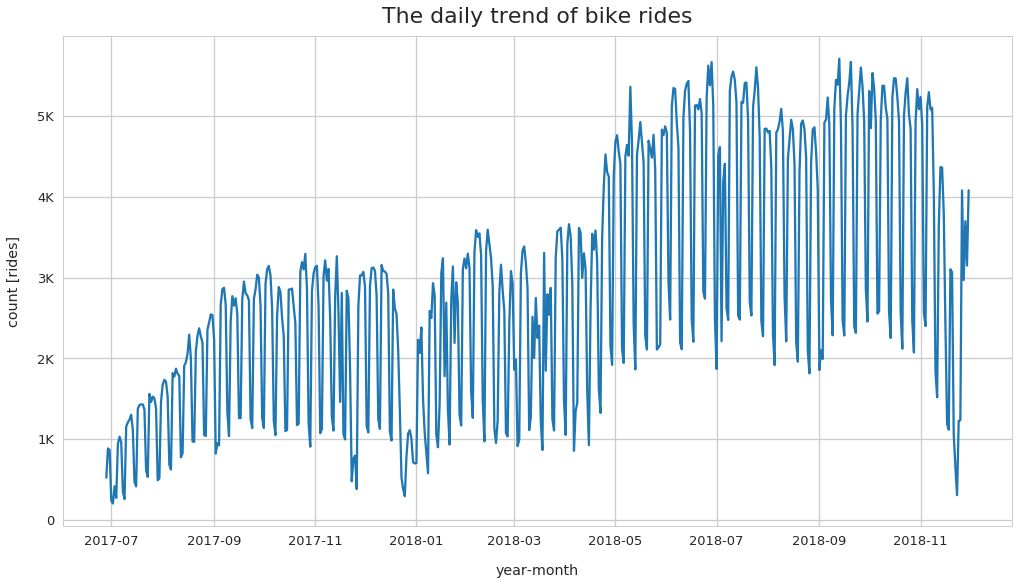

In [49]:
df.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(17,9))
plt.title('The daily trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image02.png');

Compared to begining of July 2017, where daily rides were less than 1K, it increased to more than 5000 after less than year (June 2018) There is huge decrease around January 2018 and November 2018 because it's too cold. (Winter session time starts).

In [ ]:
plt.figure(figsize=(14,8))
sns.countplot(x='start_time_year_month_renamed', palette="Greens", data=df.sort_values(by='start_time_year_month_renamed'))
plt.title('The monthly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image03.png')

Compared to begining of July 2017, where daily rides were less than 1K, it increased to more than 5000 after less than year (June 2018) There is huge decrease around January 2018 and November 2018 because it's too cold. (Winter session time starts).

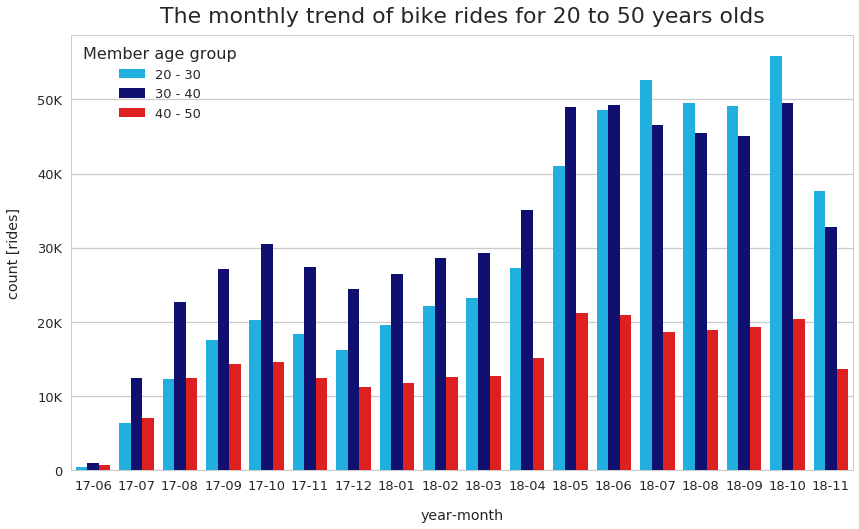

In [53]:
plt.figure(figsize=(14,8))
my_palette = {'20 - 30': 'deepskyblue', '30 - 40': 'navy', '40 - 50': 'red'}
ax = sns.countplot(x='start_time_year_month_renamed', hue='member_age_bins', palette=my_palette, data=df[df['member_age_bins'].isin(['20 - 30', '30 - 40', '40 - 50'])].sort_values(by=['start_time_year_month_renamed', 'member_age_bins']))
plt.title('The monthly trend of bike rides for 20 to 50 years olds', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image04.png');

20-30 years old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, however 20-30 years old users became leader in a year.

# Question 2. How does rides trend change per age, gender, weekday, and hour of a day?

***Total rides***

In [54]:
df['bike_id'].sum()

3314668961

There were 3.31 billion rides.

***Distrubition of bike rides vs user age group***

In [55]:
trip_by_age_df = df.groupby('member_age_bins').agg({'bike_id':'count'})

In [56]:
trip_by_age_df['perc'] = (trip_by_age_df['bike_id']/trip_by_age_df['bike_id'].sum())*100

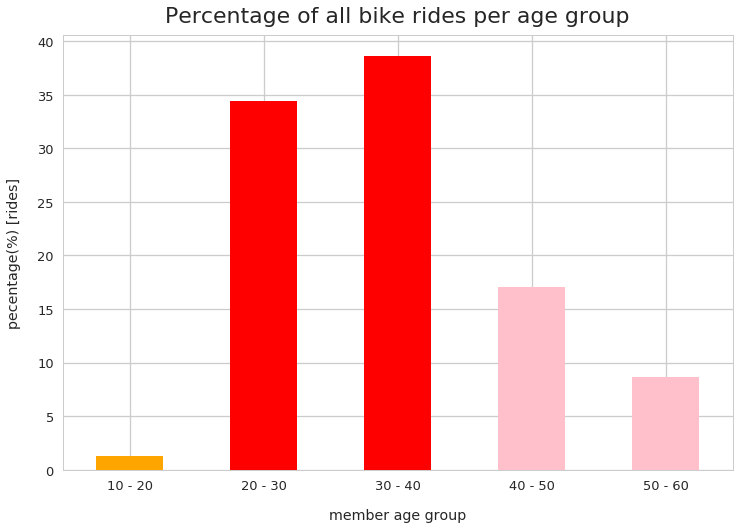

In [61]:
new_color = ['orange', 'red', 'red', 'pink', 'pink']
trip_by_age_df['perc'].plot(kind='bar', color=new_color, figsize=(12,8))
plt.title('Percentage of all bike rides per age group', fontsize=22, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image05.png');

20 to 40 years old people took the more than %70 of bike rides. Among those, 30 to 40 years old people's rides account almost %40 of all bike rides.

***Bike rides per gender***

In [62]:
trip_by_gender_df = df.groupby('member_gender').agg({'bike_id':'count'})

In [63]:
trip_by_gender_df['perc'] = (trip_by_gender_df['bike_id']/trip_by_gender_df['bike_id'].sum())*100

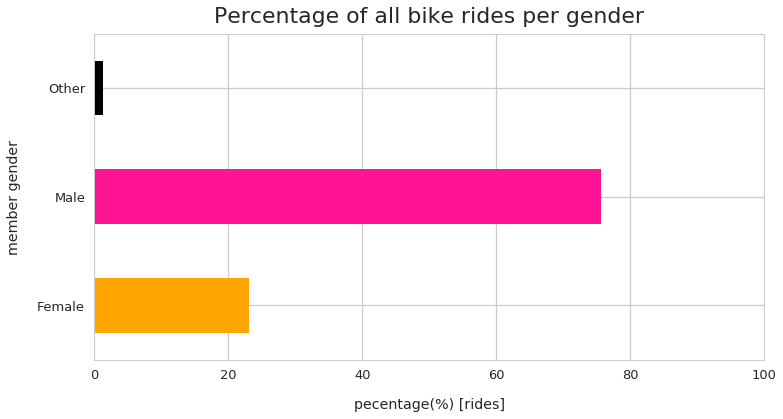

In [65]:
new_color = ['orange', 'deeppink', 'black']
trip_by_gender_df['perc'].plot(kind='barh', color=new_color, figsize=(12,6))
plt.title('Percentage of all bike rides per gender', fontsize=22, y=1.015)
plt.ylabel('member gender', labelpad=16)
plt.xlabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.xlim(0,100)
plt.savefig('image06.png');

Male took around %76 of all bike rides, and female took around %22 of them.

***Bike rides per weekday***

In [66]:
trip_by_weekday_df = df.groupby('start_time_weekday_abbr').agg({'bike_id':'count'})

In [67]:
trip_by_weekday_df['perc'] = (trip_by_weekday_df['bike_id']/trip_by_weekday_df['bike_id'].sum())*100

In [68]:
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

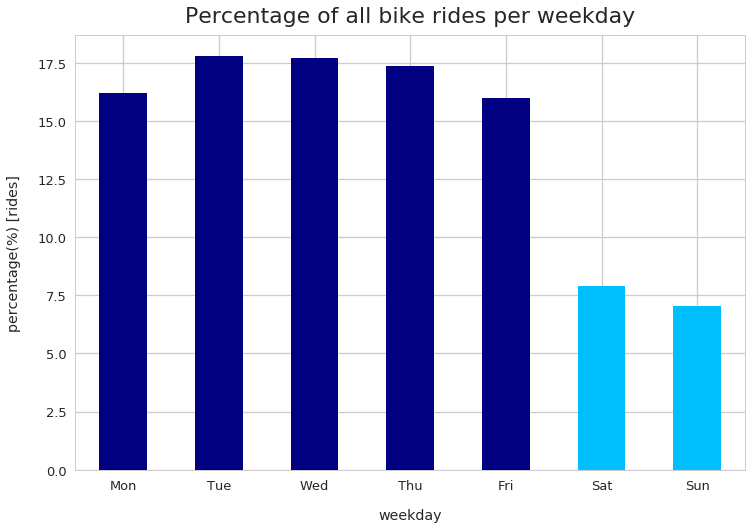

In [69]:
new_color = ['navy', 'navy', 'navy', 'navy', 'navy', 'deepskyblue', 'deepskyblue']
trip_by_weekday_df.reindex(weekday_index)['perc'].plot(kind='bar', color=new_color, figsize=(12,8), legend=False)
plt.title('Percentage of all bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image07.png');


People use this service on weekdays more than weekends.

***Peak hours of the day***

In [70]:
trip_by_hour_df = df.groupby('start_time_hour').agg({'bike_id':'count'}).reset_index()

In [71]:
trip_by_hour_df['bike_id'] = (trip_by_hour_df['bike_id']/trip_by_hour_df['bike_id'].sum())*100

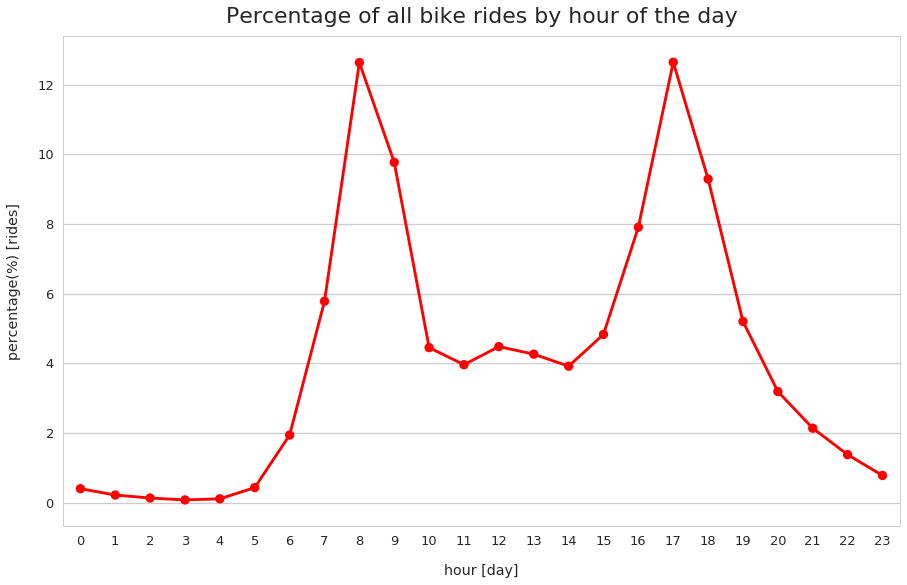

In [73]:
plt.figure(figsize=(15,9))
sns.pointplot(x='start_time_hour', y='bike_id', scale=.7, color='red', data=trip_by_hour_df)
plt.title('Percentage of all bike rides by hour of the day', fontsize=22, y=1.015)
plt.xlabel('hour [day]', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.savefig('image08.png');


8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well.

# Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

I checked each variables one by one. (Average rides, daily and monthly trend of riders, age groups, genders, weekdays or weekends comparision, peak hours, user types with distances etc.) All these variables are important in order to understand the dataset and communicating the datafindings at the end of this project.
We can talk about some of the variables. For example;
There were 3.31 billion rides.
20-30 years old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, however 20-30 years old users became leader in a year.
20 to 40 years old people took the more than %70 of bike rides. Among those, 30 to 40 years old people's rides account almost %40 of all bike rides.
Male took around %76 of all bike rides, and female took around %24 of them.
People use this service on weekdays more than weekends.
8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well.

# Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I tidy up the data which contains member ages more than 60 years old. Ages from 18 to 56 takes 95% of the users. There were users more than 100 years old. Regarding this situation and results of age distrubition, we can remove users more than 60 years old.
I generated new fields such as duration, time, age groups etc. in order to calculate them easily and understand the dataframe.
Ford GoBike spreaded the service to San Francisco, Oakland and San Jose. However, it's hard to imagine traffic. So regarding this complexity, I decided to focus on San Fancisco area by limiting with latitude and longitude.

# Bivariate Exploration

# Question 3. Are there any difference between subscribers' and customers' behaviors?

***Percentage of bike rides of subscribers vs customers***

In [74]:
count_of_rides_per_user_type = df.groupby('user_type').size().reset_index(name='count')

In [75]:
count_of_rides_per_user_type['count']/len(df)*100

0    11.842464
1    88.157536
Name: count, dtype: float64


Percentage of subscribers is almost %88.15.
Percentage of customers is almost %11.85.

***User trends of bike rides of subscribers vs customers***

In [76]:
user_type_count_per_year_df = df.groupby(["start_time_year_month_renamed", "user_type"]).size().reset_index()

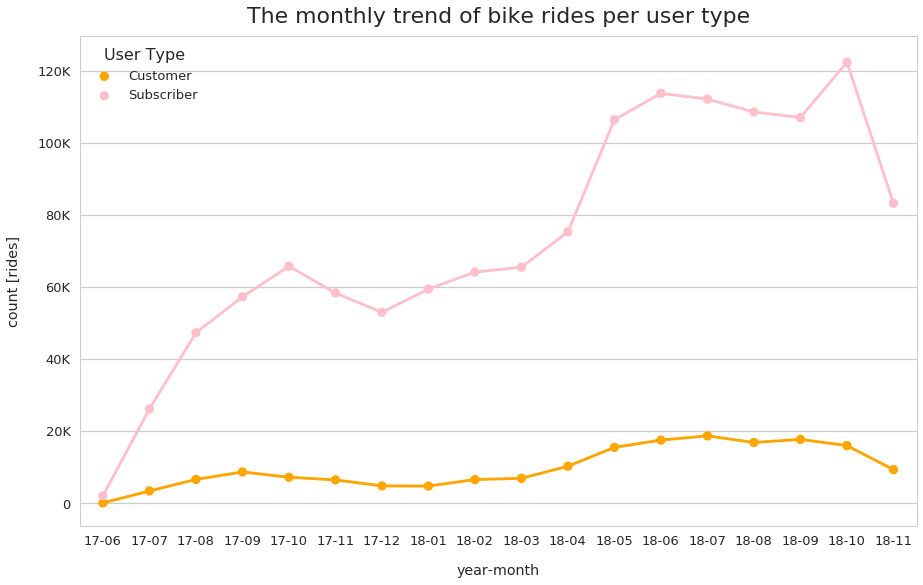

In [80]:
plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'pink', 'Customer':'orange'}
ax = sns.pointplot(x='start_time_year_month_renamed', y=0, hue='user_type', palette=my_palette, scale=.7, data=user_type_count_per_year_df)
plt.title('The monthly trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image09.png');

Customers' rides seems increasing slightly. There is a decrease on November 2018 for subscribers but it seems like it is related with winter season.



Text(0.5,0,'minutes [trip duration]')

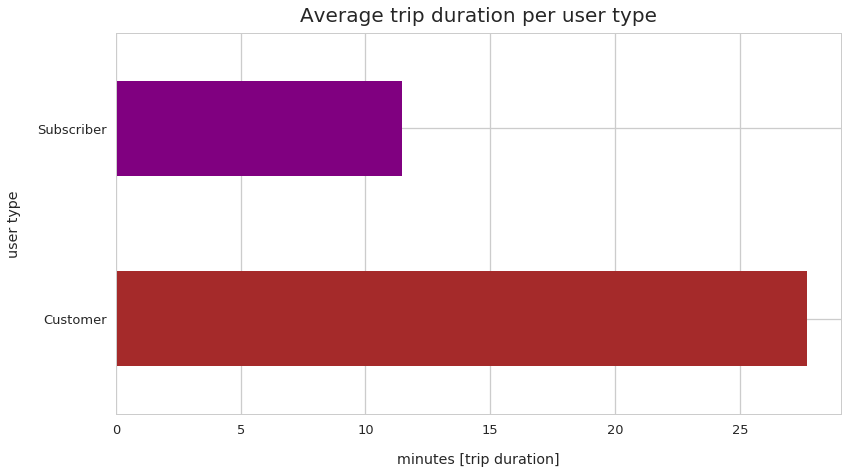

In [81]:
new_color=['brown', 'purple']
ax = df.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip duration per user type', fontsize=20, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('minutes [trip duration]', labelpad=16)

Subscribers' average trip duration is around 11 minutes.

Customers' average trip duration is around 28 minutes.

***Average trip distance of subscribers vs customers***

Text(0.5,0,'miles [distance]')

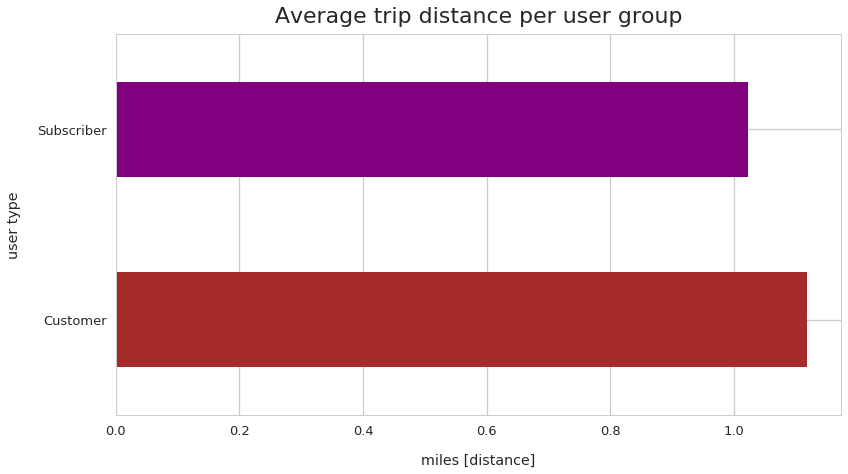

In [82]:
ax = df.groupby('user_type')['distance_miles_estimates'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip distance per user group', fontsize=22, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('miles [distance]', labelpad=16)

Subscribers and customers trip distance were about the same, which is slightly more than one mile.

***The trend of subscribers' bike rides per age group***

In [83]:
subscriber_age_df = df[df['user_type']=='Subscriber'].groupby(['start_time_year_month_renamed', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()

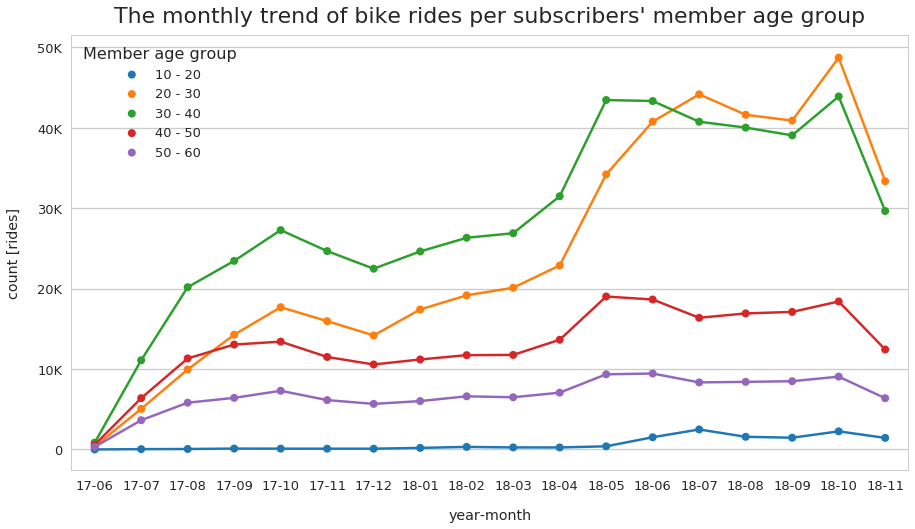

In [84]:
plt.figure(figsize=(15,8))
ax = sns.pointplot(x='start_time_year_month_renamed', y='bike_id', hue='member_age_bins', scale=.6, data=subscriber_age_df)
plt.title("The monthly trend of bike rides per subscribers' member age group", fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image12.png');

***Main purpose bike rides for subscribers and customers (20~40 years age group)***

In [85]:
subscriber_hour_df = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [86]:
subscriber_hour_df['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [87]:
subscriber_hour_df['count_perc'] = subscriber_hour_df['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [88]:
subscriber_hour_df['rank'] = subscriber_hour_df['count_perc'].rank(ascending=False).astype(int)

In [89]:
subscriber_hour_df_pivoted = subscriber_hour_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [90]:
customer_hour_df = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Customer') 
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [91]:
customer_hour_df['start_time_weekday_abbr'] = pd.Categorical(customer_hour_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [92]:
customer_hour_df['count_perc'] = customer_hour_df['count'].apply(lambda x: (x/customer_hour_df['count'].sum())*100) #male

In [93]:
customer_hour_df['rank'] = customer_hour_df['count_perc'].rank(ascending=False).astype(int)

In [94]:
customer_hour_df_pivoted = customer_hour_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank').astype(int)

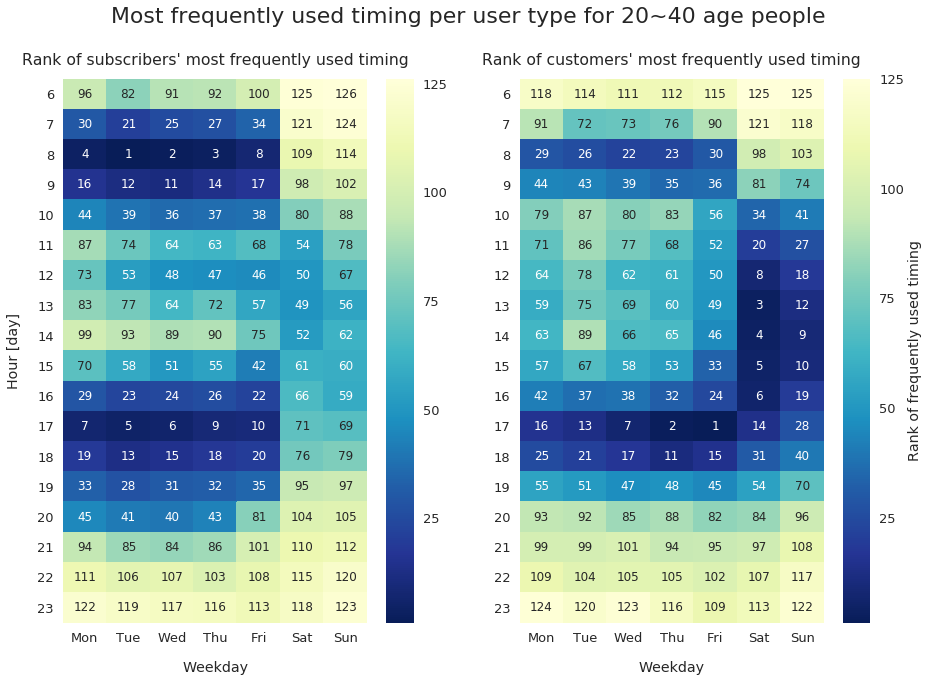

In [95]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Most frequently used timing per user type for 20~40 age people', fontsize=22)
sns.heatmap(subscriber_hour_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12})
plt.title("Rank of subscribers' most frequently used timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour [day]', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sns.heatmap(customer_hour_df_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of frequently used timing'})
plt.title("Rank of customers' most frequently used timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.savefig('image13.png');


Subscribers are most frequently used this service around 7~9am and 4~6pm.
Customers are used this service at weekend around 10am~5pm and weekday 5pm~6pm. Customers use this service during weekend for leisure and weekdays after work.

# Question 4. How is the trend of electric bike rides and which age group favors E-Bike more?

Ford GoBike annouced the launch of electric bikes as April 24th, 2018. It can be implied that the new electric bikes were added in a week after April 24th.

***Predict electric bike***

In [96]:
non_electric_bike_id = df[df['start_time'] < pd.Timestamp(2018,4,24)]['bike_id'].unique()

In [97]:
electric_bike_id = []
for bike_id in df[(df['start_time'] > pd.Timestamp(2018, 4, 24)) & (df['start_time'] < pd.Timestamp(2018, 5, 24))]['bike_id']: 
    if bike_id not in non_electric_bike_id and bike_id not in electric_bike_id:
        electric_bike_id.append(bike_id)

In [98]:
len(electric_bike_id)

313

In [99]:
df['electric_bike_id'] = df['bike_id'].isin(electric_bike_id)

***Verification of electric bikes with box plot for the first month***

In [100]:
electric_bike_verification_df = df[(df['start_time']>pd.Timestamp(2018, 4, 24))&(df['start_time']<pd.Timestamp(2018, 5, 24))].groupby(['start_time_date','bike_id']).size().reset_index()

In [101]:
electric_bike_verification_df = electric_bike_verification_df.rename(columns={0:'count'})

In [102]:
electric_bike_verification_df['bike_type']=electric_bike_verification_df['bike_id'].apply(lambda x: 'electric' if x in electric_bike_id else 'non-electric')

In [103]:
electric_bike_verification_df['start_time_date'] = electric_bike_verification_df['start_time_date'].map(lambda x: x.strftime('%m-%d'))

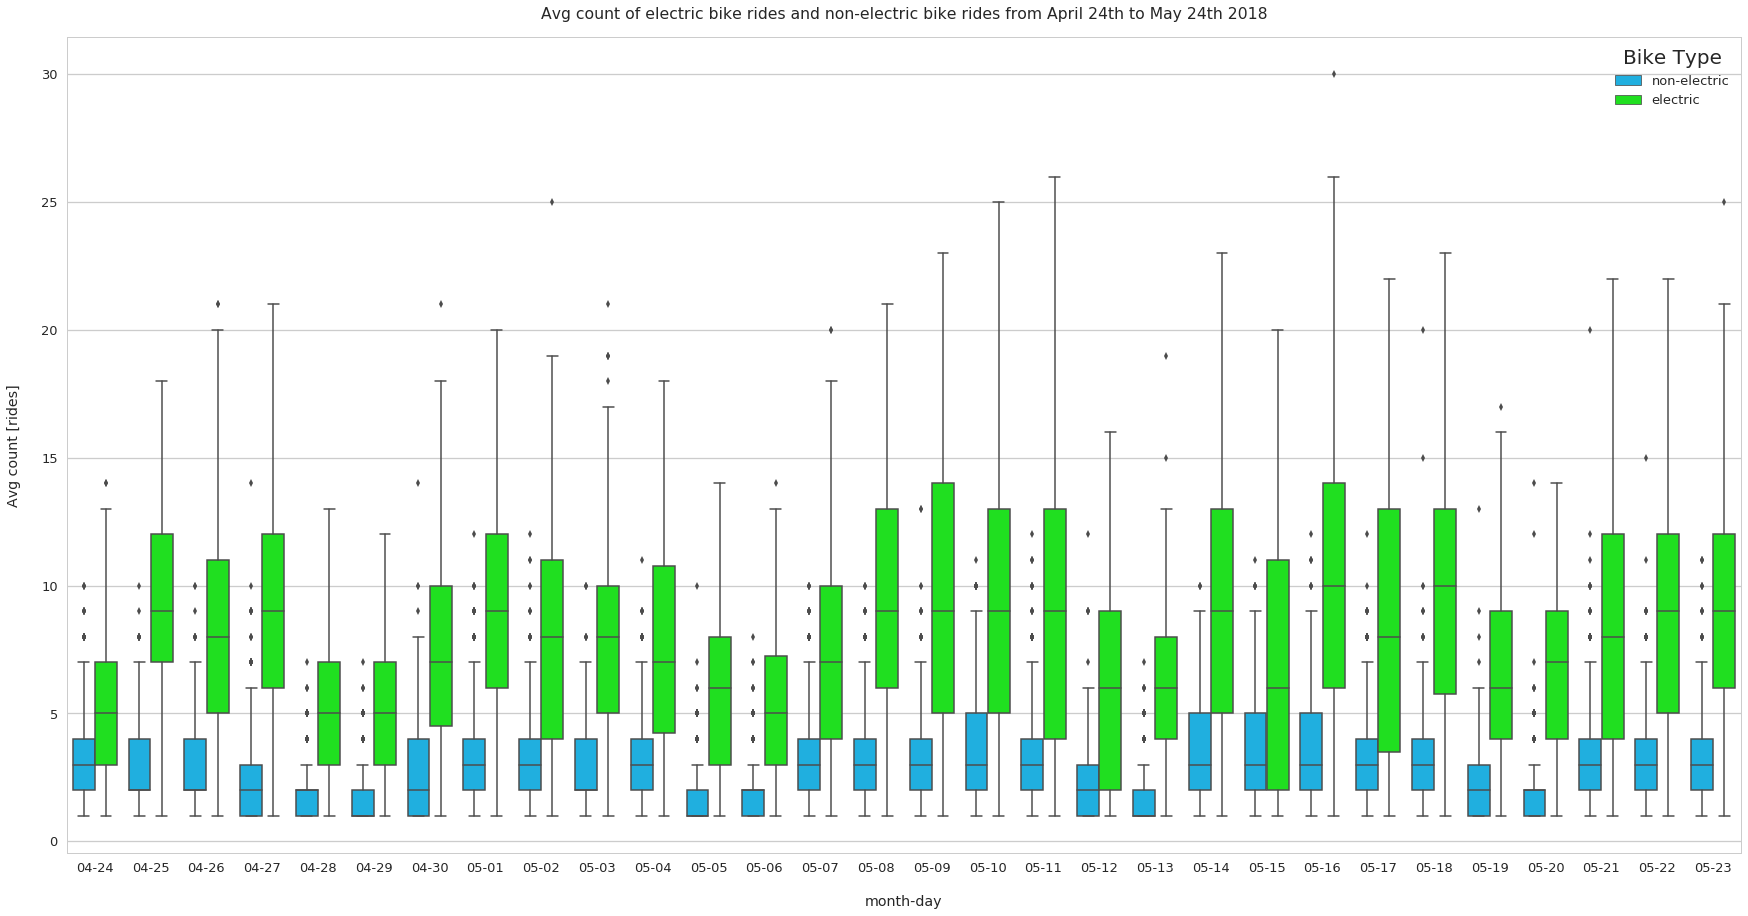

In [104]:
plt.figure(figsize=(30,15))
my_palette = {"electric":"lime", 'non-electric':'deepskyblue'}
ax = sns.boxplot(x='start_time_date', y='count', hue='bike_type', linewidth=1.5, palette=my_palette, data=electric_bike_verification_df)
plt.title('Avg count of electric bike rides and non-electric bike rides from April 24th to May 24th 2018', y=1.015)
plt.xlabel('month-day', labelpad=20)
plt.ylabel('Avg count [rides]', labelpad=20)
leg = ax.legend()
leg.set_title('Bike Type',prop={'size':20})
plt.savefig('image16.png');


There is huge difference between electric bike and normal bike rides.
After the news of new launch of electric bike service, there may be high demands on riding electric bikes.

***Count of daily electric bike rides from April 24th 2018 to November 30th 2018***

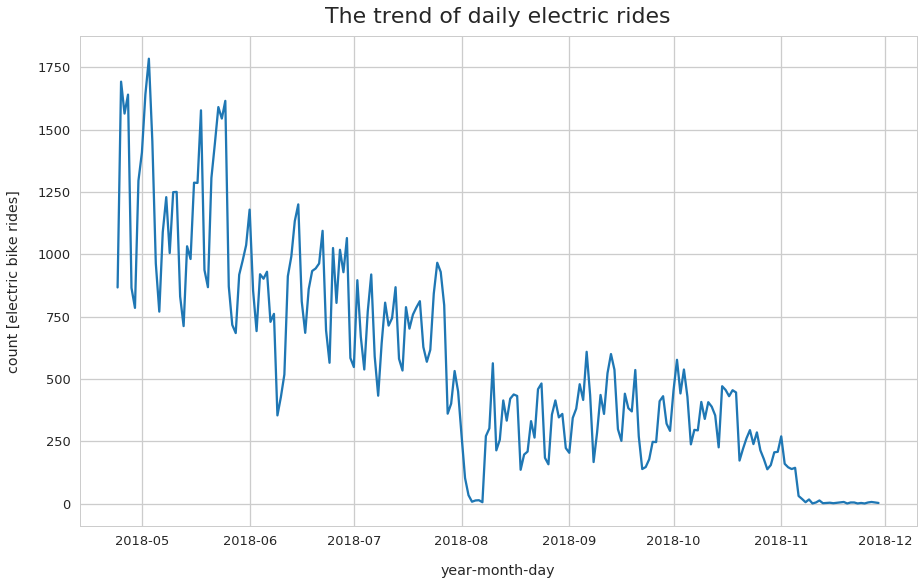

In [105]:
electric_df = df[df['electric_bike_id']==1].reset_index()
electric_df.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(15,9))
plt.title('The trend of daily electric rides', fontsize=22, y=1.015)
plt.xlabel('year-month-day', labelpad=16)
plt.ylabel('count [electric bike rides]', labelpad=16)
plt.savefig('image16.png');



There is a huge spike at the end of April. After that, it seems the usage trend for electric bikes are decreasing

# Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Percentage of subscribers is almost %88.15. Percentage of customers is almost %11.85.
Customers' rides seems increasing slightly. There is a decrease on November 2018 for subscribers but it seems like it is related with winter season.
Subscribers' average trip duration is around 11 minutes. Customers' average trip duration is around 28 minutes.
Subscribers and customers trip distance were about the same, which is slightly more than one mile.
I selected the most popular group 20-40 years old people in order to compare hiring days, time of the day, peak times etc.
Subscribers are most frequently used this service around 7~9am and 4~6pm. Customers are used this service at weekend around 10am~5pm and weekday 5pm~6pm. Customers use this service during weekend for leisure and weekdays after work.
On the other hand, i checked the electrical bike program. Ford GoBike annouced the launch of electric bikes as April 24th, 2018. 91.9% of rides are non-electric bike rides. Electric bike rides accounts for 8.1% of the total rides in the first month. It was inreased suddenly at the beginning of the program launch. There is a huge spike at the end of April. After that, it seems the usage trend for electric bikes are decreasing.

# Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

I observed that at the beginning of electrical bike hiring program launch there was a high demand about this program. But after a while, it was decreased suddenly. Customers and subscribers may be more comfortable to drive a normal or ramdom bike rather than a electrical and advanced technological bikes.

# Multivariate Exploration


I want to explore in this part of the analysis is how the three variables (Age group, weekdays, timeframe of subscribers) in relationship with hiring. Because, subscribers are more common and hiring partners of this program.

In [106]:
subscriber_hour_df2 = df[(df['member_age']>=20) & (df['member_age']<30) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [107]:
subscriber_hour_df3 = df[(df['member_age']>=30) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [108]:
subscriber_hour_df4 = df[(df['member_age']>=40) & (df['member_age']<50) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [109]:
subscriber_hour_df2['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df2['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [110]:
subscriber_hour_df3['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df3['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [111]:
subscriber_hour_df4['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df4['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [112]:
subscriber_hour_df2['count_perc'] = subscriber_hour_df2['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [113]:
subscriber_hour_df3['count_perc'] = subscriber_hour_df3['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [114]:
subscriber_hour_df4['count_perc'] = subscriber_hour_df4['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [115]:
subscriber_hour_df2['rank'] = subscriber_hour_df2['count_perc'].rank(ascending=False).astype(int)

In [116]:
subscriber_hour_df3['rank'] = subscriber_hour_df3['count_perc'].rank(ascending=False).astype(int)

In [120]:
subscriber_hour_df4['rank'] = subscriber_hour_df4['count_perc'].rank(ascending=False).astype(int)

In [121]:
subscriber_hour_df_pivoted2 = subscriber_hour_df2.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [122]:
subscriber_hour_df_pivoted3 = subscriber_hour_df3.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [123]:
subscriber_hour_df_pivoted4 = subscriber_hour_df4.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

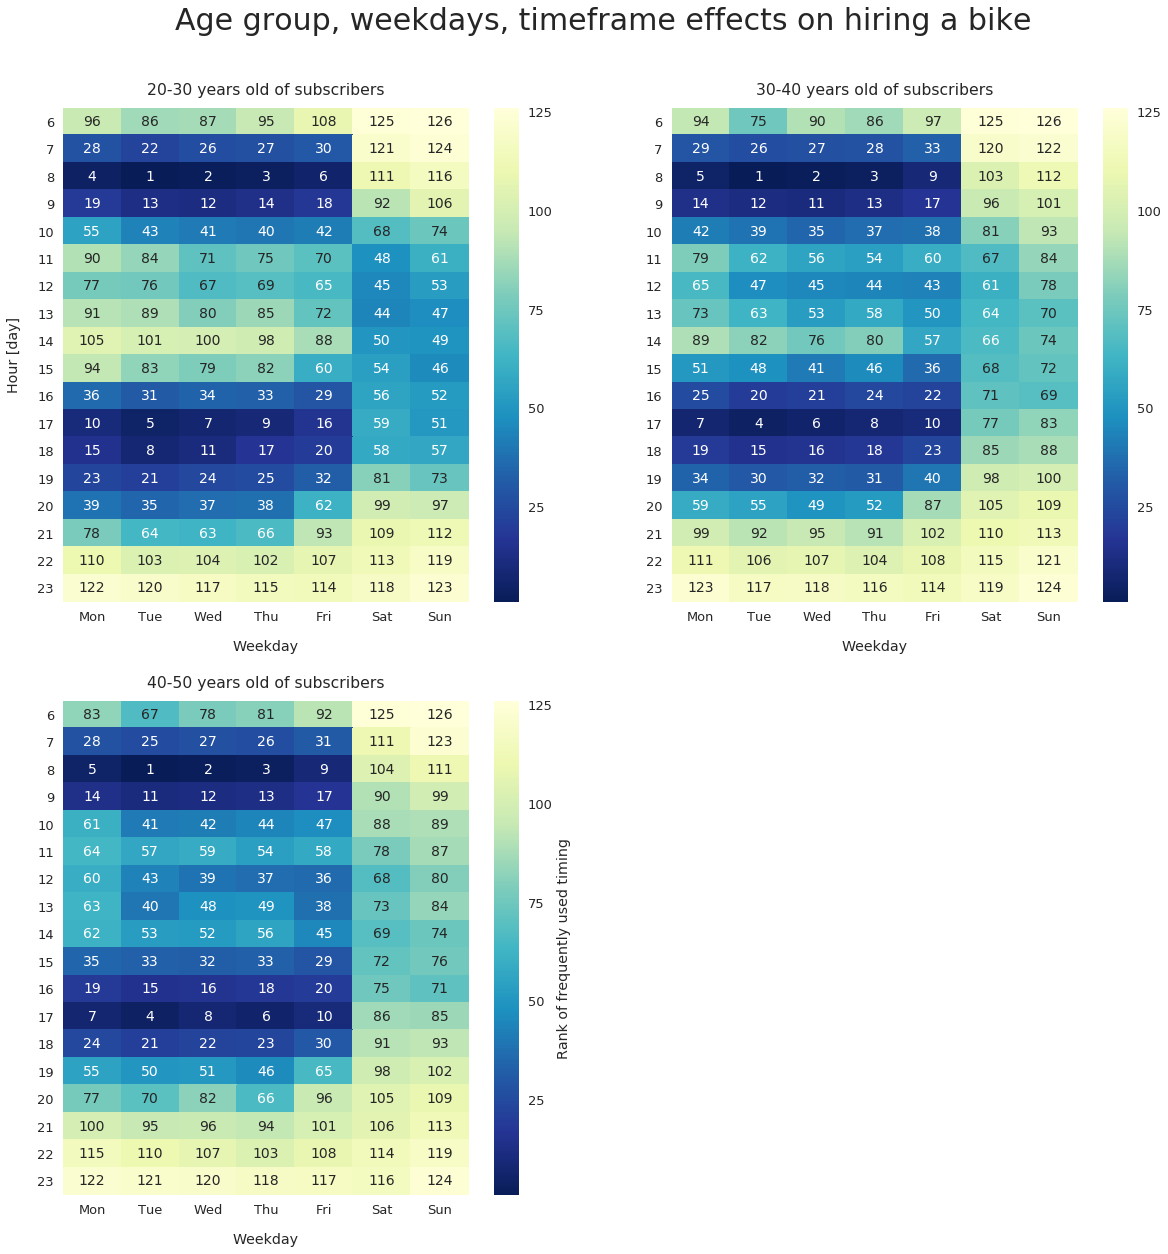

In [124]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.suptitle('Age group, weekdays, timeframe effects on hiring a bike', fontsize=30, y=0.95)
sns.heatmap(subscriber_hour_df_pivoted2, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 14})
plt.title("20-30 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour [day]', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(222)
sns.heatmap(subscriber_hour_df_pivoted3, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 14})
plt.title("30-40 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.subplot(223)
sns.heatmap(subscriber_hour_df_pivoted4, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 14}, cbar_kws={'label': 'Rank of frequently used timing'})
plt.title("40-50 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.savefig('image18.png');


# Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I extended my investigation of bike hiring with 3 different variables such as age group, timeframe, weekday. The multivariate exploration here showed me that people who are older than the others have more time to drive a bike rather than a young people. 20-30 years old people are active when the time is commute like they drive a bike when they go to their offices or come back to their homes. These figures shows us when we become older, we can see that they drive these bikes everytime in a day like in the lunch time or in the morning or in the afternoon. It may be related with their retirement or older people have much more flexiable working hours rather than youngers.

# Were there any interesting or surprising interactions between features?

I was interested and also surprised because i did not expect to see these kind of figures for 40-50 years old group. I was expecting to see much less hiring quantities in a day but these figures show that they are active and they are flexiable rather than youngers.

# Conclusion

There were 3.31 billion rides. 20-30 years old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, however 20-30 years old users became leader in a year. 20 to 40 years old people took the more than %70 of bike rides. Among those, 30 to 40 years old people's rides account almost %40 of all bike rides. Male took around %76 of all bike rides, and female took around %24 of them. People use this service on weekdays more than weekends. 8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well. Percentage of subscribers is almost %88.15. Percentage of customers is almost %11.85. Customers' rides seems increasing slightly but subscibers' rides reached 6 times more than customers' on October 2018. There is a decrease on November 2018 for subscribers but it seems like it is related with winter season. Subscribers' average trip duration is around 11 minutes. Customers' average trip duration is around 28 minutes. Subscribers and customers trip distance were about the same, which is slightly more than one mile. 90% of bike rides take place on weekday. The peak bike rides time for all members is around commute time.

Finally, it seems that 40 to 50 years old age group use the service the most. After Ford GoBike did a pilot launch of e-bike on April 24th 2018, there have been quite a lot of electric bike rides as well, which reached to 10% of daily rides at the end of July 2018. However, daily electric bike rides is on downward trend.